In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from mdp_description import MDPDescription
from new_mdp_description import MDPDescription2
from scipy.special import rel_entr
from utils import project_omega,compute_stationary_distribution, unit_vector, angle_between, gram_schmidt
import matplotlib.ticker as mticker
from riverswim import RiverSwim
N_SIMS = 20
NS = 5
NEPS = np.linspace(0, 1, 10)
NA = 4
discount_factor = 0.99
np.random.seed(2)

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=1.96):
    return x.mean(0), c * x.std(0) / np.sqrt(x.shape[0])


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})


In [2]:
random_res_U_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_U_gen_proj = np.zeros((N_SIMS, len(NEPS)))
random_res_U_nc = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_gen_proj = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_nc = np.zeros(( N_SIMS, len(NEPS)))
random_res_U_C = np.zeros(N_SIMS)


for sim in tqdm(range(N_SIMS)):
    while True:
        try:
            P0 = np.ones((NS, NA, NS)) / NS
            P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            mdp = MDPDescription2(P, R, discount_factor, 1)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            random_res_U_C[sim] = mdp.evaluate_allocation(omega_nav_constr)      
            
            for id_eps, eps in enumerate(NEPS):
                Ptheta = (1-eps) * P + eps * P0
                mdp_theta = MDPDescription2(Ptheta, R, discount_factor, 1)
                
                omega_gen_theta = mdp_theta.compute_allocation()[0]
                omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
                random_res_U_nc[sim, id_eps] = mdp.evaluate_allocation(omega_nav_constr_theta)
                random_res_TV_nc[sim, id_eps] = TV(omega_nav_constr_theta, omega_nav_constr)
                
                # Forced projected generative
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta, Ptheta)
                random_res_U_gen_stationary[sim, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                random_res_TV_gen_stationary[sim, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_proj = project_omega(omega_gen_theta, Ptheta, force_policy=False)
                random_res_U_gen_proj[sim, id_eps] = TV(omega_gen_proj, omega_nav_constr)
                random_res_TV_gen_proj[sim, id_eps] = mdp.evaluate_allocation(omega_gen_proj, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue



with open('./data/data_generative_comparison_nc_randommdp.pkl', 'wb') as f:
    pickle.dump({'random_res_U_gen_stationary': random_res_U_gen_stationary, 'random_res_TV_gen_stationary': random_res_TV_gen_stationary,
                 'random_res_U_gen_proj': random_res_U_gen_proj, 'random_res_TV_gen_proj': random_res_TV_gen_proj,
                 'random_res_U_nc': random_res_U_nc, 'random_res_TV_nc': random_res_TV_nc,
                 'random_res_U_C': random_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 20/20 [03:10<00:00,  9.51s/it]


In [27]:
riverswim_res_U_gen_stationary = np.zeros(len(NEPS))
riverswim_res_U_gen_proj = np.zeros(len(NEPS))
riverswim_res_U_nc = np.zeros(len(NEPS))
riverswim_res_TV_gen_stationary = np.zeros(len(NEPS))
riverswim_res_TV_gen_proj = np.zeros(len(NEPS))
riverswim_res_TV_nc = np.zeros(len(NEPS))
riverswim_res_U_C = 0

env = RiverSwim(num_states=20)

while True:
    try:
        P0 = np.ones((20, 2, 20)) / 20
        P = env.transitions
        R = env.rewards
        mdp = MDPDescription2(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        for id_eps, eps in enumerate(NEPS):
            Ptheta = (1-eps) * P + eps * P0
            mdp_theta = MDPDescription2(Ptheta, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            riverswim_res_U_nc[id_eps] = mdp.evaluate_allocation(omega_nav_constr_theta)
            riverswim_res_TV_nc[id_eps] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            omega_gen_stationary = compute_stationary_distribution(omega_gen_theta, Ptheta)
            riverswim_res_U_gen_stationary[id_eps] = TV(omega_gen_stationary, omega_nav_constr)
            riverswim_res_TV_gen_stationary[id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

            # Unforced projected generative
            omega_gen_proj = project_omega(omega_gen_theta, Ptheta, force_policy=False)
            riverswim_res_U_gen_proj[id_eps] = TV(omega_gen_proj, omega_nav_constr)
            riverswim_res_TV_gen_proj[id_eps] = mdp.evaluate_allocation(omega_gen_proj, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_riverswim.pkl', 'wb') as f:
    pickle.dump({'riverswim_res_U_gen_stationary': riverswim_res_U_gen_stationary, 'riverswim_res_TV_gen_stationary': riverswim_res_TV_gen_stationary,
                 'riverswim_res_U_gen_proj': riverswim_res_U_gen_proj, 'riverswim_res_TV_gen_proj': riverswim_res_TV_gen_proj,
                 'riverswim_res_U_nc': riverswim_res_U_nc, 'riverswim_res_TV_nc': riverswim_res_TV_nc,
                 'riverswim_res_U_C': riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
with open('./data/data_generative_comparison_nc_randommdp.pkl', 'rb') as f:
    data = pickle.load(f)
    

random_res_U_gen_stationary = data['random_res_U_gen_stationary']
random_res_U_gen_proj = data['random_res_U_gen_proj']
random_res_U_nc = data['random_res_U_nc']
random_res_TV_gen_stationary = data['random_res_TV_gen_stationary']
random_res_TV_gen_proj = data['random_res_TV_gen_proj']
random_res_TV_nc = data['random_res_TV_nc']
random_res_U_C = data['random_res_U_C']


with open('./data/data_generative_comparison_nc_riverswim.pkl', 'rb') as f:
    data = pickle.load(f)
    

riverswim_res_U_gen_stationary = data['riverswim_res_U_gen_stationary']
riverswim_res_U_gen_proj = data['riverswim_res_U_gen_proj']
riverswim_res_U_nc = data['riverswim_res_U_nc']
riverswim_res_TV_gen_stationary = data['riverswim_res_TV_gen_stationary']
riverswim_res_TV_gen_proj = data['riverswim_res_TV_gen_proj']
riverswim_res_TV_nc = data['riverswim_res_TV_nc']
riverswim_res_U_C = data['riverswim_res_U_C']

[]

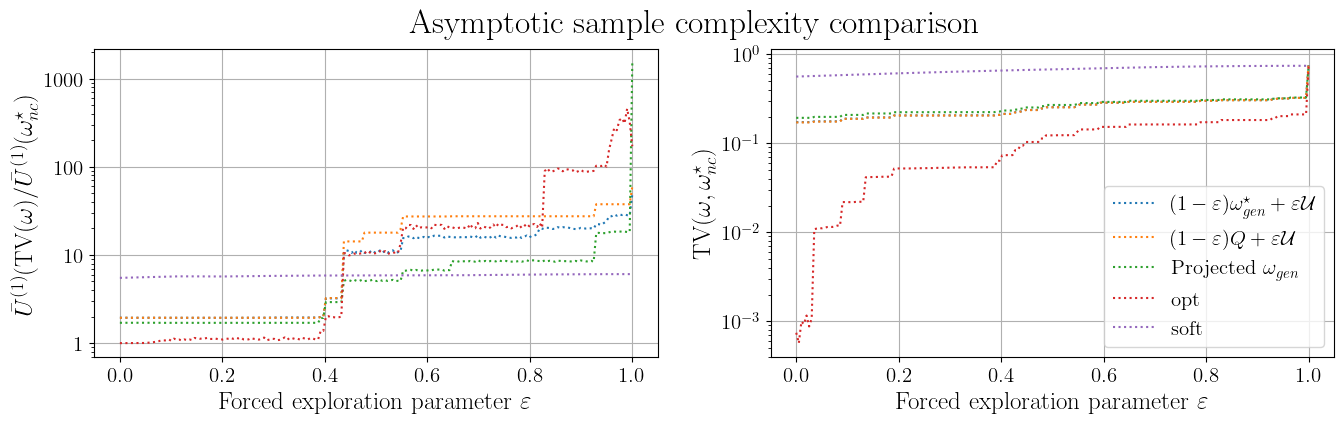

In [53]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}

for id_ns, ns in enumerate([NS[-1]]):
    for id_na, na in enumerate(NA):
        mu0 = np.median(res_U_C[id_ns, id_na], 0)
        ##
        mu = np.median(res_U_gen_proj_forced[id_ns, id_na] / mu0, 0)
        ax[0].plot(NTHETAS, mu, label=r'$(1-\varepsilon)\omega_{gen}^\star +\varepsilon {\cal U}$', linestyle=linestyles[na], marker=markers[ns])
        ##
        mu = np.median(res_U_Qgreedy_proj[id_ns, id_na] / mu0, 0)
        ax[0].plot(NTHETAS, mu, label=r'$(1-\varepsilon)Q+\varepsilon {\cal U}$', linestyle=linestyles[na], marker=markers[ns])
        
        ## Soft
        mu = np.median(res_U_gen_proj[id_ns, id_na] / mu0, 0)
        ax[0].plot(NTHETAS, mu, label=r'Projected $\omega_{gen}$', linestyle=linestyles[na], marker=markers[ns])
        
        ## Opt
        mu = np.median(res_U_opt[id_ns, id_na] / mu0, 0)
        ax[0].plot(NTHETAS, mu, label=r'opt', linestyle=linestyles[na], marker=markers[ns])
        
        mu = np.median(res_U_soft[id_ns, id_na] / mu0, 0)
        ax[0].plot(NTHETAS, mu * np.ones(len(NTHETAS)), label=r'soft', linestyle=linestyles[na], marker=markers[ns])

        mu, se = CE(res_TV_gen_proj_forced[id_ns, id_na])
        ax[1].plot(NTHETAS, mu, linestyle=linestyles[na], marker=markers[ns])
    
        mu, se = CE(res_TV_Qgreedy[id_ns, id_na])
        ax[1].plot(NTHETAS, mu, linestyle=linestyles[na], marker=markers[ns])
        
        mu, se = CE(res_TV_gen_proj[id_ns, id_na])
        ax[1].plot(NTHETAS, mu, linestyle=linestyles[na], marker=markers[ns])
        
        mu, se = CE(res_TV_opt[id_ns, id_na])
        ax[1].plot(NTHETAS, mu, linestyle=linestyles[na], marker=markers[ns])
        
        mu, se = CE(res_TV_soft[id_ns, id_na])
        ax[1].plot(NTHETAS, mu * np.ones(len(NTHETAS)), linestyle=linestyles[na], marker=markers[ns])

# ax[0].plot(NTHETAS, 1*np.ones_like(NTHETAS), 'k--')
# ax[0].text(3e-2, 1.07, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].grid()
ax[0].set_xlabel(r'Forced exploration parameter $\varepsilon$')
ax[0].set_ylabel(r'$\bar U^{(1)}({\rm TV}(\omega)/\bar U^{(1)}(\omega_{nc}^\star)$')
ax[0].yaxis.set_major_formatter(mticker.ScalarFormatter())


#ax[1].set_xscale('log')
ax[1].grid()
ax[1].set_yscale('log')
#ax[1].set_ylim(0.15, 0.3)
ax[1].set_xlabel(r'Forced exploration parameter $\varepsilon$')
ax[1].set_ylabel(r'${\rm TV}(\omega, \omega_{nc}^\star)$')
#ax[1].yaxis.set_minor_formatter(mticker.ScalarFormatter())

h1, l1 = ax[0].get_legend_handles_labels()

#h1.insert(2, plt.plot([],marker="", ls="")[0])
#h1.insert(0, plt.plot([],marker="", ls="")[0])
#l1.insert(2, f'$|A|={NA[1]}$')
#l1.insert(0, f'$|A|={NA[0]}$')
ax[1].legend(h1, l1,  ncols=1)
plt.suptitle(f'Asymptotic sample complexity comparison')
#plt.tight_layout()
#plt.savefig('plot_random_mdp_comparison_Q.pdf', bbox_inches='tight')
plt.plot()

In [115]:
with open('data_results_comparation.pkl', 'wb') as f:
    pickle.dump({'res_U': res_U, 'res_TV': res_TV}, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
mdp.compute_optimal_soft_policy(0.99, 0.1)

(array([24.69829444, 24.6585924 , 24.68014368, 24.70692345, 24.7109887 ]),
 array([[0.07230443, 0.05661809, 0.05864786, 0.06253249, 0.06391261,
         0.07655513, 0.07630051, 0.06730098, 0.05215477, 0.0604513 ,
         0.06160212, 0.06378146, 0.07913117, 0.07356905, 0.07513803],
        [0.0678934 , 0.07400663, 0.07869642, 0.04801262, 0.0474403 ,
         0.07109504, 0.08188492, 0.06524472, 0.06161042, 0.09494331,
         0.06600347, 0.06831358, 0.04768575, 0.08512028, 0.04204914],
        [0.06976023, 0.08038673, 0.07355628, 0.07366727, 0.070992  ,
         0.06099625, 0.07623186, 0.07167553, 0.07119501, 0.06474539,
         0.05642985, 0.05987312, 0.06166822, 0.07274439, 0.03607784],
        [0.06819225, 0.06487191, 0.0703976 , 0.07221864, 0.0644642 ,
         0.0629695 , 0.06382807, 0.06297787, 0.07470316, 0.06358586,
         0.06558927, 0.06889003, 0.06592431, 0.0631725 , 0.06821484],
        [0.06868295, 0.06986417, 0.06568141, 0.06865809, 0.06479218,
         0.05910383, 0.0

In [2]:
eps=0.01
ns=2
na=2
discount_factor=0.99
P = np.random.dirichlet(np.ones(ns), size=(ns, na))
R = np.random.dirichlet(np.ones(ns), size=(ns, na))
mdp = MDPDescription2(P, R, discount_factor, 1)
omega_gen = mdp.compute_allocation()[0]
omega_nav_constr, omega_nav_constr_val = mdp.compute_allocation(navigation_constraints=True)
omega_gen_eps = eps * np.ones((ns, na)) / (ns*na) + (1-eps) * omega_gen



In [9]:
# Unforced projected generative
omega_gen_proj = project_omega(omega_gen_eps, mdp.P, force_policy=False)
omega_gen_proj_forced = project_omega(omega_gen_eps, mdp.P, force_policy=True)

v1 = omega_nav_constr - omega_gen_proj
v2 = omega_nav_constr - omega_gen_proj_forced

vectors = gram_schmidt([v1.flatten(), v2.flatten()])

# print(omega_nav_constr - omega_gen_eps)
# print(vectors[0])

0.9999999977843743

/home/alessio/rl-exploration-maze/RandomMDP/new_mdp_description.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  T1 = self.normalizer * (2 + 8 * golden_ratio * self.Mk_V_greedy[s,a]) / (omega[s,a] * self.delta_sq[s,a])
/home/alessio/rl-exploration-maze/RandomMDP/new_mdp_description.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  T2 = self.normalizer * (2 + 8 * golden_ratio * self.Mk_V_greedy[sp, self.pi_greedy[sp]]) / (omega[sp, self.pi_greedy[sp]] * self.delta_sq[s,a] * ((1 - self.discount_factor) ** 2))


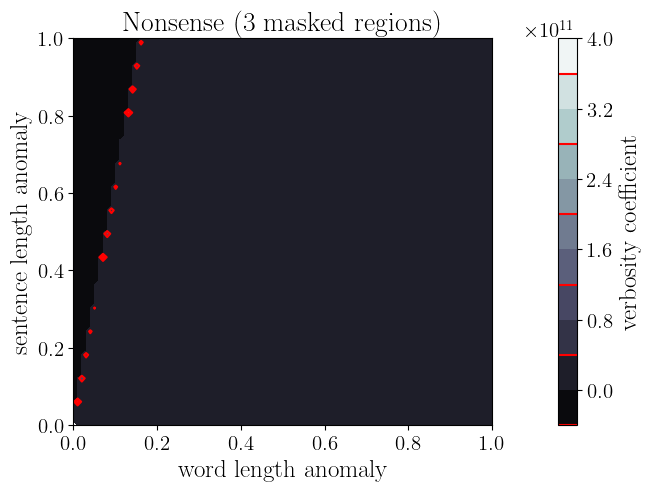

In [17]:
alphas = np.linspace(0, 1, 100)

Zvalues = []
Yvalues = []
X, Y = np.meshgrid(alphas, alphas)
Z = np.zeros((len(alphas), len(alphas)))



for i in range(100):
    for j in range(100):
        z = omega_gen_proj.flatten() + X[i,j] * vectors[0]
        y = omega_gen_proj_forced.flatten() + Y[i,j] * vectors[1]

        Z[i,j] = mdp.evaluate_allocation((z+y).reshape(ns,na))
    
fig1, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone)
CS2 = ax2.contour(CS, levels=CS.levels[::2], colors='r')

ax2.set_title('Nonsense (3 masked regions)')
ax2.set_xlabel('word length anomaly')
ax2.set_ylabel('sentence length anomaly')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('verbosity coefficient')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)


In [20]:
P = np.random.dirichlet(np.ones(ns), size=(ns, na))
R = np.random.dirichlet(np.ones(ns), size=(ns, na))
mdp = MDPDescription2(P, R, discount_factor, 1)

for theta in [0.1, 0.5, 1, 5, 10, 50, 100]:
    soft_policy = mdp.compute_optimal_soft_policy(0.99, theta)[1]

    omega_soft = compute_stationary_distribution(soft_policy, P)

    print(mdp.evaluate_allocation(omega_soft))

3435264348423.9917
3424379087686.975
3423015337614.499
3421923815183.5796
3421787341901.5503
3421678157972.495


KeyboardInterrupt: 

In [55]:
theta = 0.2
Ptheta = (1-theta) * P + theta * P0
                        
mdp = MDPDescription2(P, R, discount_factor, 1)
mdp_theta = MDPDescription2(Ptheta, R, discount_factor, 1)


soft_policy = mdp_theta.compute_optimal_soft_policy(0.99, 5e-5)[1]

soft_policy

array([[0.02765239, 0.32085277, 0.33144217, 0.32005267],
       [0.3119974 , 0.12302464, 0.31197753, 0.25300044],
       [0.27241469, 0.38975515, 0.10304524, 0.23478492],
       [0.30914327, 0.00106287, 0.3454207 , 0.34437316],
       [0.08998682, 0.30542563, 0.30928096, 0.29530659]])

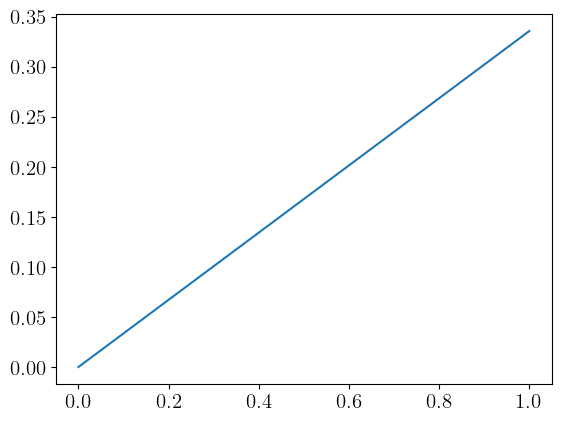

In [59]:
P0 = np.ones((ns, na, ns)) / ns
P = np.random.dirichlet(np.ones(ns), size=(ns, na))
thetas = np.linspace(0,1, 100)
from scipy.special import rel_entr

v = []
for theta in thetas:
    Ptheta = (1-theta) * P + theta * P0
    
    M = (P+Ptheta)/2
    kl =  np.abs(Ptheta-P).sum(-1).mean()/2#  rel_entr(Ptheta,P).sum(-1).mean()#(rel_entr(P, M).sum(-1) + rel_entr(Ptheta, M).sum(-1))/2
    v.append(kl.mean())

plt.plot(thetas, v)
    